# Opening of the data

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [1]:
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors

Using TensorFlow backend.


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 28 13:00:48 2018

@author: rniel
"""
dataset_path = "datasets/review_rating/"

def open_uci(x_=[],y_=[],choice=["movie","amazon","yelp"]):
    dataset_path = "datasets/polarization/"
    if ("movie" in choice):
        file  = open(dataset_path+"imdb_labelled.txt", "rt")
        content = file.read()
        contents=[]
        contents=content.split("\n")
        del contents[-1]
        for c in contents:
            temp=c.split("\t")
            x_.append(temp[0])
            y_.append(int(temp[1]))

    if ("amazon" in choice):
        file  = open(dataset_path+"amazon_cells_labelled.txt", "rt")
        content = file.read()
        contents=[]
        contents=content.split("\n")
        del contents[-1]

        for c in contents:
            temp=c.split("\t")
            x_.append(temp[0])
            y_.append(int(temp[1]))

    if ("yelp" in choice):
        file  = open(dataset_path+"yelp_labelled.txt", "rt")
        content = file.read()
        contents=[]
        contents=content.split("\n")
        del contents[-1]


        for c in contents:
            temp=c.split("\t")
            x_.append(temp[0])
            y_.append(int(temp[1]))
    return x_,y_

def open_book(x_=[],y_=[]):
    file  = open(dataset_path+"book.txt", "rt")
    
    nb_duplicate = 0
    
    content = file.read()
    contents=[]
    contents=content.split("\n")
    del contents[-1]
    del contents[-1]
    
    for c in contents:
        temp=c.split("\t")
        if(temp[1] in x_):
            nb_duplicate+=1
        else : 
            x_.append(temp[1])
            y_.append(int(temp[0]))  
    return x_,y_

def open_movie(x_=[],y_=[]):
    file  = open(dataset_path+"rt-polarity-neg.txt", "rt",encoding = "ISO-8859-1")

    content = file.read()
    contents=[]
    contents=content.split("\n")
    del contents[-1]
    del contents[-1]

    for i in range(len(contents)):
        x_.append(contents[i])
        y_.append(0)

    file  = open(dataset_path+"rt-polarity-pos.txt", "rt",encoding = "ISO-8859-1")
    content = file.read()
    contents=[]
    contents=content.split("\n")
    del contents[-1]
    del contents[-1]

    for i in range(len(contents)):
        x_.append(contents[i])
        y_.append(1)    
    return x_,y_

def pretreatment(sentences):
    # This function take a list of sentences and treat them to remove all punctuation mark and higher case
    to_delete = [",",".","-","!","?",":","*",")","(","'",'"',"\n","0","1","2","3","4","5","6","7","8","9"]

    for i in range(len(sentences)):
        for t in to_delete:
            sentences[i] = sentences[i].replace(t," ")

    ret_sentences = []
    for s in sentences:
        ret_sentences.append(s.split(" "))

    for i in range(len(sentences)):
        ret_sentences[i]=[w for w in ret_sentences[i] if w!=""]

    for i in range(len(ret_sentences)):
        for j in range(len(ret_sentences[i])) :
            ret_sentences[i][j]=ret_sentences[i][j].lower()
    return ret_sentences
    
def vectorization(sentences,vectors,word_length=300,max_len=50,adaptable_len=False):
    """ This function transform an array of list of words (the splitted sentences) into a array of list of vectors 
            representing the words thanks to an already trained word2Vec model
            
        Keyword arguments:
        sentences -- The different sentences you want to vectorize
        word2vec_model -- An already trained gensim Word2Vec model
        word_length -- The number of dimension of the vectors representing the words (default 300) 
        max_len -- The maximum length of a sentence (default 50) 
        adaptable_len -- A boolean allowing to adapt the maximum length to the longest sentence in your dataset
    """
    sentences_v=[]
    unusued_word=[]

    sp_words = set(stopwords.words('english'))    
    
    for s in sentences:
        temp=[]
        for w in s :
            if(w not in sp_words):
                try :
                    temp.append(np.float32(vectors[w]))
                except : 
                    unusued_word.append(w)
        sentences_v.append(temp)
        
    if (adaptable_len == True):
        for s in sentences_v:
            if(len(s)>max_len):
                max_len=len(s)
                
    for s in sentences_v:
        sentence_length = len(s)
        if(sentence_length<max_len):    
            for j in range(max_len-sentence_length):
                s.append([0]*word_length)
    return sentences_v,max_len

def load_google_word2vec(vocabulary_size = 300000, path = 'lib/GoogleNews-vectors-negative300.bin'):
    # load the google word2vec model
    model = KeyedVectors.load_word2vec_format(path,binary = True,limit=vocabulary_size)  
    return model

def protocol_test(config,model,length_sentences,x_test=[],y_test=[]):

    names = ["amazon","yelp","movies"]
    mean = []
    
    for n in names :
        x, y = open_uci([],[],choice = n)
        for i in range(len(x)) : 
            if("not" in x[i]):
                x[i] = treatment_negation(x[i])
        sentences_v,max_len = vectorization(pretreatment(x),model,word_length=300,max_len=length_sentences,adaptable_len=True)
        y_pred = config.predict(np.array(sentences_v))
        y_pred = np.argmax(y_pred,axis=1)
        cf = confusion_matrix(y,y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix : \n "+ str (cf))
        mean.append(acc)
        print("Accuracy and loss for the "+str(n)+" dataset : "+ str(acc) +"\n")
    
    print("Mean for the 3 datasets = "+str(np.mean(mean))+"\n")
        
    if (len(x_test)!=0 and len(y_test)!=0):
        y_pred = np.argmax(config.predict(np.array(x_test)),axis=1)
        cf = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix :\n "+str(cf))
        print("Evaluation on the test set : "+str(acc))
        
def protocol_test_embedding(config,tokenizer,length_sentences,x_test=[],y_test=[]):

    names = ["amazon","yelp","movies"]
    mean = []
    
    for n in names :
        x, y = open_uci([],[],choice = n)
        for i in range(len(x)) : 
            if("not" in x[i]):
                x[i] = treatment_negation(x[i])
            
            sentences_v = []        
            for s in x :
                sentences_v.append(text_to_word_sequence(s))
        sentences_v = tokenize(sentences_v,tokenizer,length_sentences)
        y_pred = config.predict(np.array(sentences_v))
        y_pred = np.argmax(y_pred,axis=1)
        print(len(y_pred))
        cf = confusion_matrix(y,y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix : \n "+ str (cf))
        mean.append(acc)
        print("Accuracy and loss for the "+str(n)+" dataset : "+ str(acc) +"\n")
    
    print("Mean for the 3 datasets = "+str(np.mean(mean))+"\n")
        
    if (len(x_test)!=0 and len(y_test)!=0):
        y_pred = np.argmax(config.predict(np.array(x_test)),axis=1)
        cf = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix :\n "+str(cf))
        print("Evaluation on the test set : "+str(acc))

def protocol_test_embedding_gensim(config,word2vec_model,length_sentences,x_test=[],y_test=[]):

    names = ["amazon","yelp","movies"]
    mean = []
    
    for n in names :
        x, y = open_uci([],[],choice = n)
        for i in range(len(x)) : 
            if("not" in x[i]):
                x[i] = treatment_negation(x[i])
            
            sentences_v = []        
            for s in x :
                sentences_v.append(text_to_word_sequence(s))
        sentences_v = tokenize(word2vec_model,sentences_v,length_sentences)
        y_pred = config.predict(np.array(sentences_v))
        y_pred = np.argmax(y_pred,axis=1)
        cf = confusion_matrix(y,y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix : \n "+ str (cf))
        mean.append(acc)
        print("Accuracy and loss for the "+str(n)+" dataset : "+ str(acc) +"\n")
    
    print("Mean for the 3 datasets = "+str(np.mean(mean))+"\n")
        
    if (len(x_test)!=0 and len(y_test)!=0):
        y_pred = np.argmax(config.predict(np.array(x_test)),axis=1)
        cf = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix :\n "+str(cf))
        print("Evaluation on the test set : "+str(acc))

        
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/robin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def treatment_negation_sentences(sentences):
    ret_sentences = []
    punctuation = [",",".","!","?",":"]

    for s in sentences:
        for p in punctuation :
            s = s.replace(p," "+p)
        ret_sentences.append(s.split(" "))
        
    for s in ret_sentences:
        for i in range(len(s)):
            if (s[i] == 'not'):
                j = i +1
                if (j < len(s)):
                    while (j< len(s) or (not(s[j] in punctuation) and s[j]!= "")):
                        s[j] = "not"+s[j]
                        j+=1
                        if (j>=len(s)):
                            break
        for i in range(len(ret_sentences)):
            ret_sentences[i] = " ".join(ret_sentences[i])

    return ret_sentences

def treatment_negation(sentence):
    
    punctuation = [",",".","!","?",":"]
    sp_words = set(stopwords.words('english'))    

    for p in punctuation :
        sentence = sentence.replace(p," "+p)
    
    sentence = sentence.split(" ")
    
    for i in range(len(sentence)):
        if (sentence[i] == 'not'):
            j = i
            if (j < len(sentence)):
                while (j< len(sentence) and (not(sentence[j] in punctuation) and sentence[j]!= "")):
                    if (sentence[j] == "not"):
                        sentence[j] = ""
                        j+=1
                    elif(not(sentence[j] in punctuation) and (sentence)) : 
                        sentence[j] = "not"+sentence[j]
                        j+=1
                        if (j>=len(sentence)):
                            break
                    else : 
                        j+=1
    sentence = " ".join(sentence)                    
    return sentence
    

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 28 13:00:48 2018

@author: rniel
"""
import csv
from keras.preprocessing.text import text_to_word_sequence

x = []
y = []
i = 0
with open(dataset_path+'Womens_Clothing.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        if(i!=0):
            x.append(row[4])
            y.append(int(row[5]))
        i+=1    
del x[0]
del y[0]

for i in range(len(x)) :
    if ("not" in x[i]):
        x[i]=treatment_negation(x[i])

print("Length of x :"+str(len(x)))
sentences = []
for s in x :
    sentences.append(text_to_word_sequence(s))

Length of x :23485


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 28 13:00:48 2018

@author: rniel
"""
import csv
from keras.preprocessing.text import text_to_word_sequence

x = []
y = []
i = 0
with open(dataset_path+'Womens_Clothing.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        if(i!=0):
            x.append(row[4])
            y.append(int(row[5]))
        i+=1    
del x[0]
del y[0]

print("Length of x :"+str(len(x)))
sentences = []
for s in x :
    sentences.append(text_to_word_sequence(s))

Length of x :23485


## Transforming of the y

In [5]:
def transform(y):
    if(y>3):
        return 0
    if(y==3):
        return 1
    if(y<3):
        return 2

y = [transform(y_tmp) for y_tmp in y]    


In [11]:
def transform_x_y(x,y):
    x_good = []
    y_good = []
    for i in range(len(x)):
        if y[i] != 3:
            x_good.append(x[i])
            y_good.append(y[i])
    return x_good,y_good

def transform(y):
    if(y>3):
        return 1
    if(y<3):
        return 0

sentences,y = transform_x_y(sentences,y)     
y = [transform(y_tmp) for y_tmp in y]    


In [7]:
len(x)

23485

In [12]:
import numpy as np
import json

with open(dataset_path+'Movies_and_TV_5.json', 'r') as jsonfile:
    transformed_path = dataset_path+'transformed/'
    i = 0
    for line in jsonfile : 
        tmp = json.loads(line)
        x.append(tmp['reviewText'])
        y.append(int(tmp['overall']))
        i+=1
        if (i>5000):
            break

In [8]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec.load("variables/review_rating/not/model")

In [4]:
word2vec_model = load_google_word2vec()

In [10]:
from keras.preprocessing.sequence import pad_sequences

def tokenize(word2vec_model,sentences,length_sentences=None) :
    sentences_t = []
    unusued_words = []
    for s in sentences :
        sentence_tmp = []
        for w in s :
            try:
                sentence_tmp.append(word2vec_model.wv.vocab[w].index) 
            except : 
                unusued_words.append(w)
        sentences_t.append(sentence_tmp)
    
    sentences_ret = pad_sequences(np.array(sentences_t),maxlen=length_sentences)    
    for i in range(len(sentences_ret)):
        sentences_ret[i] = np.flip(sentences_ret[i],axis=0)
        
    return sentences_ret

In [11]:
sentences_toke = tokenize(word2vec_model,sentences,150)

# Word2Vec training part

In [14]:
from gensim.models.word2vec import Word2Vec
WORD_LENGTH = 300
sentences = pretreatment(x)
model = Word2Vec(sentences, size=WORD_LENGTH, min_count=10, workers=4,sorted_vocab=1)
model.train(sentences,total_examples=len(sentences), epochs=10)

(9001486, 13761630)

In [15]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

print("Number of line of Electronics_5.json : "+str(file_len("datasets/review_rating/Electronics_5.json")))
print("Number of line of Movies_and_TV_5.json : " +str(file_len("datasets/review_rating/Movies_and_TV_5.json")))

Number of line of Electronics_5.json : 1689188
Number of line of Movies_and_TV_5.json : 1697533


In [19]:
import json
import time        

from gensim.models.word2vec import Word2Vec

def amazon_word2vec_training(model,name_file,upper_bound,lower_bound,batch_size):
    x = []
    start_time = time.time()
    mean = []
    with open("datasets/review_rating/"+name_file, 'r') as jsonfile:
        i = 0
        j = 1
        for line in jsonfile :
            if(i>lower_bound):
                tmp = json.loads(line)
                """                if ("not" in tmp['reviewText']):
                    x.append(treatment_negation(tmp['reviewText']))
                else :"""
                x.append(tmp['reviewText'])
                if(j%batch_size == 0):
                    sentences = pretreatment(x)
                    model.build_vocab(sentences,update=True)
                    model.train(sentences,total_examples = len(sentences),epochs = 10)
                    j = 1
                    x = []
                    mean.append((time.time()-start_time)/60)
                    print("ETA : "+str(np.mean(mean)*((upper_bound-i)/batch_size))+" mn")
                    print("Current vocab size  : "+str(len(model.wv.vocab)))                    
                    start_time=time.time()
            
            i+=1
            j+=1
            if(i>upper_bound):
                break
        model.save('variables/review_rating/word2vec/300/Model_300')
        print("Model saved to the disk")
    return model    

In [20]:
import numpy as np
indices = np.arange(0,1700000,step=50000,dtype=int)

In [22]:
for i in range(len(indices)-1):
    print(str(i)+" ieme step on "+str(len(indices)-1))
    model = amazon_word2vec_training(model,'Movies_and_TV_5.json',indices[i+1],indices[i],5000)
    #Movies_and_TV_5
    #Electronics_5

0 ieme step on 33
ETA : 1.2257172566866874 mn
Current vocab size  : 17695
ETA : 0.9937115635871888 mn
Current vocab size  : 18697
ETA : 0.9024401582739089 mn
Current vocab size  : 19519
ETA : 0.7698069095214207 mn
Current vocab size  : 20287
ETA : 0.644639560713768 mn
Current vocab size  : 20994
ETA : 0.529883586857319 mn
Current vocab size  : 21634
ETA : 0.39598643728926064 mn
Current vocab size  : 22042
ETA : 0.26356578224658966 mn
Current vocab size  : 22400
ETA : 0.12948586883589075 mn
Current vocab size  : 22697
ETA : 0.0002544063766797384 mn
Current vocab size  : 23036
Model saved to the disk
1 ieme step on 33
ETA : 0.9492056180024147 mn
Current vocab size  : 23324
ETA : 0.8593710138368607 mn
Current vocab size  : 23652
ETA : 0.7952738237955836 mn
Current vocab size  : 23960
ETA : 0.727881087384224 mn
Current vocab size  : 24260
ETA : 0.6272310505700113 mn
Current vocab size  : 24505
ETA : 0.5052776167472204 mn
Current vocab size  : 24769
ETA : 0.3865769240438371 mn
Current vocab

ETA : 0.41687599139769876 mn
Current vocab size  : 43676
ETA : 0.2763774231934547 mn
Current vocab size  : 43785
ETA : 0.13811950755499028 mn
Current vocab size  : 43886
ETA : 0.00027431417465209964 mn
Current vocab size  : 44023
Model saved to the disk
14 ieme step on 33
ETA : 1.3594420090587933 mn
Current vocab size  : 44149
ETA : 1.2198319445872305 mn
Current vocab size  : 44259
ETA : 1.046340640540388 mn
Current vocab size  : 44351
ETA : 0.8706704793715476 mn
Current vocab size  : 44481
ETA : 0.7105013511705399 mn
Current vocab size  : 44596
ETA : 0.5591439854979515 mn
Current vocab size  : 44703
ETA : 0.4186719166470709 mn
Current vocab size  : 44839
ETA : 0.27728651076078414 mn
Current vocab size  : 44971
ETA : 0.14117368093428787 mn
Current vocab size  : 45101
ETA : 0.0002822356192270915 mn
Current vocab size  : 45219
Model saved to the disk
15 ieme step on 33
ETA : 1.5226033005142212 mn
Current vocab size  : 45363
ETA : 1.294508281824589 mn
Current vocab size  : 45479
ETA : 1.0

ETA : 0.8149463092684748 mn
Current vocab size  : 54734
ETA : 0.6924858853395781 mn
Current vocab size  : 54775
ETA : 0.5932777561513584 mn
Current vocab size  : 54801
ETA : 0.49318615956544887 mn
Current vocab size  : 54839
ETA : 0.4053635573866633 mn
Current vocab size  : 54896
ETA : 0.3081214146413122 mn
Current vocab size  : 54958
ETA : 0.20468112851858136 mn
Current vocab size  : 54985
ETA : 0.1023344936827377 mn
Current vocab size  : 55013
ETA : 0.00020500581900278724 mn
Current vocab size  : 55058
Model saved to the disk
28 ieme step on 33
ETA : 1.2900175298873582 mn
Current vocab size  : 55097
ETA : 0.9301318612980843 mn
Current vocab size  : 55132
ETA : 0.7794240366856258 mn
Current vocab size  : 55184
ETA : 0.6676717017412186 mn
Current vocab size  : 55211
ETA : 0.5630428004479409 mn
Current vocab size  : 55256
ETA : 0.44410922421879245 mn
Current vocab size  : 55310
ETA : 0.335461861776965 mn
Current vocab size  : 55376
ETA : 0.2181061296200752 mn
Current vocab size  : 55402

In [11]:
len(model.wv.vocab)

59941

In [12]:
model.save("variables/review_rating/not/model")

In [30]:
model.save('variables/review_rating/word2vec/model_300')

In [16]:
model.train(sentences,total_examples=len(sentences),epochs=10)

(257229853, 347177000)

# Transformation of sentences into list of vectors

In [12]:
sentences_v,max_len = vectorization(sentences,word2vec_model.wv,word_length=300,adaptable_len=True)

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


# Splitting of the data into train and test set (non toke)

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
x_vec_train,x_vec_test,y_vec_train,y_vec_test = train_test_split(sentences_v,y,test_size=0.2,random_state=42)
x_vec_train=np.array(x_vec_train)
x_vec_test=np.array(x_vec_test)
from keras.utils import to_categorical
y_vec_train=to_categorical(y_vec_train)
y_vec_test=to_categorical(y_vec_test)  

# Splitting of the data into train and test set (toke)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
x_vec_train,x_vec_test,y_vec_train,y_vec_test = train_test_split(sentences_toke,y,test_size=0.2,random_state=42)
x_vec_train=np.array(x_vec_train)
x_vec_test=np.array(x_vec_test)
from keras.utils import to_categorical
y_vec_train=to_categorical(y_vec_train)
y_vec_test=to_categorical(y_vec_test)  

# Neural network creation

In [16]:
# Neural Network
from keras.layers import Input, Dense,Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM,Dropout, Embedding,BatchNormalization
from keras.models import Model

def model_creation():
    
    max_len=150
    inputs = Input(shape = (max_len,))
    emb = word2vec_model.wv.get_keras_embedding(train_embeddings=True)(inputs)
    #x = Dropout(0.5)(emb)
    x = Dense(max_len, activation='relu')(emb)
    x = Dropout(0.5)(x)    
    x = Convolution1D(64,kernel_size=10,activation='relu',border_mode='causal')(emb)
    #x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding='same')(x)
    x = LSTM(50)(x)
    x = Dropout(0.5)(x)
    x = Dense(250, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(250, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(6,activation = "softmax")(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
x_vec_test,x_vec_valid,y_vec_test,y_vec_valid =  train_test_split(x_vec_test,y_vec_test,test_size=0.5,random_state=42)
print("Nombre de données de validation : "+str(len(x_vec_valid)))
print("Nombre de données de test : "+str(len(x_vec_test)))

Nombre de données de validation : 2349
Nombre de données de test : 2348


# Training of the model

In [9]:
def schedule(epochs,old_lr):
    lr = old_lr
    if (epochs<8):
        lr = 7e-4
    elif (epochs<15):
        lr = 3e-4
    elif (epochs<30):
        lr = 1e-4
    return lr

In [ ]:
from keras.models import clone_model
import time 
from keras.callbacks import LearningRateScheduler
NN = model_creation()
#validation_data=(x_vec_valid,y_vec_valid)
#,callbacks=[LearningRateScheduler(schedule, verbose=0)]
hist_300_4 = NN.fit(x_vec_train, y_vec_train, callbacks=[LearningRateScheduler(schedule, verbose=0)], epochs=30,batch_size =100,validation_split=0.1)
from matplotlib import pyplot as plt

plt.figure(figsize=(13,8))

plt.plot(hist_300_4.history["val_acc"],'r*-')
plt.plot(hist_300_4.history["acc"],'b*-')
plt.legend(("Validation accuracy with schedule","Training accuracy with schedule"))
plt.savefig("documents/Acc_google_new2")
plt.show()    

In [17]:
import time
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,patience=0,verbose=0, mode='auto')

NN = model_creation()

hist_google = NN.fit(x_vec_train, y_vec_train, epochs=30, batch_size=1028,validation_split=0.1,callbacks=[checkpointer])
NN.load_weights('weights.hdf5')

print("The training took "+str((time.time()-start_time)/60)+" mn")

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", padding="causal")`
  del sys.path[0]


Train on 16909 samples, validate on 1879 samples
Epoch 1/30
16909/16909 [==============================] - 8s 482us/step - loss: 0.3660 - acc: 0.8413 - val_loss: 0.3489 - val_acc: 0.8333

Epoch 00001: val_loss improved from inf to 0.34889, saving model to weights.hdf5
Epoch 2/30
16909/16909 [==============================] - 4s 244us/step - loss: 0.3432 - acc: 0.8456 - val_loss: 0.3539 - val_acc: 0.8333

Epoch 00002: val_loss did not improve from 0.34889
Epoch 3/30
16909/16909 [==============================] - 4s 253us/step - loss: 0.3402 - acc: 0.8460 - val_loss: 0.3622 - val_acc: 0.8333

Epoch 00003: val_loss did not improve from 0.34889
Epoch 4/30
16909/16909 [==============================] - 4s 242us/step - loss: 0.3388 - acc: 0.8461 - val_loss: 0.3581 - val_acc: 0.8333

Epoch 00004: val_loss did not improve from 0.34889
Epoch 5/30
16909/16909 [==============================] - 4s 232us/step - loss: 0.3372 - acc: 0.8474 - val_loss: 0.3628 - val_acc: 0.8333

Epoch 00005: val_loss 

In [18]:
NN.evaluate(x_vec_test,y_vec_test)

4697/4697 [==============================] - 5s 1ms/step


[0.34040658617872416, 0.83333331314787]

In [24]:
protocol_test_embedding_gensim(NN_test,word2vec_model,150,x_vec_train,y_vec_train)

Confusion matrix : 
 [[374 126]
 [  8 492]]
Accuracy and loss for the amazon dataset : 0.866

Confusion matrix : 
 [[268 232]
 [ 15 485]]
Accuracy and loss for the yelp dataset : 0.753

Confusion matrix : 
 [[371 129]
 [ 22 478]]
Accuracy and loss for the movies dataset : 0.849

Mean for the 3 datasets = 0.8226666666666667

Confusion matrix :
 [[ 1372   577]
 [  636 13906]]
Evaluation on the test set : 0.9264447274270814


# Generator part

## Outside Word2vec part

In [18]:
import json
import time        
from keras.utils import to_categorical
import numpy as np

def transform_x_y(x,y):
    x_good = []
    y_good = []
    for i in range(len(x)):
        if y[i] != 3:
            x_good.append(x[i])
            y_good.append(y[i])
    return x_good,y_good


def transform(y):
    if(y>3):
        return 1
    if(y<3):
        return 0

def my_generator(vectors):

    
    with open(dataset_path+'Movies_and_TV_5.json', 'r') as jsonfile:
        x = []
        WORD_LENGTH =300
        y_tmp=[]
        i = 0
        j = 1
        while(1):
            for line in jsonfile :
                tmp = json.loads(line)
                x.append(tmp['reviewText'])
                y_tmp.append(int(tmp['overall']))
                if(j%2000 == 0):
                    sentences = pretreatment(x)
                    sentences_v,max_len = vectorization(sentences,vectors,word_length=WORD_LENGTH,max_len=59)
                    x_train = []
                    y_train = []
                    sentences_v,y_tmp = transform_x_y(sentences_v,y_tmp)
                    for k in range(len(sentences_v)):
                        if(len(sentences_v[k])==max_len):
                            x_train.append(sentences_v[k])
                            y_train.append(y_tmp[k])

                    x_train = np.array(x_train)
                    y_train = [transform(y_tmp) for y_tmp in y_train]    
                    y_train = to_categorical(y_train)

                    x = []
                    y = []
                    yield (x_train,y_train)
                i+=1
                j+=1

## Embedding part

In [7]:
import json
import time        
from keras.utils import to_categorical
import numpy as np 

def transform_x_y(x,y):
    x_good = []
    y_good = []
    for i in range(len(x)):
        if y[i] != 3:
            x_good.append(x[i])
            y_good.append(y[i])
    return x_good,y_good

def transform(y):
    if(y>3):
        return 1
    if(y<3):
        return 0

def my_generator(dataset='Movies_and_TV_5.json'):

    
    with open(dataset_path+dataset, 'r') as jsonfile:
        x = []
        y=[]
        i = 0
        j = 1
        max_len = 150
        while(1):
            for line in jsonfile :
                tmp = json.loads(line)
                x.append(tmp['reviewText'])
                y.append(int(tmp['overall']))
                if(j%2000 == 0):
                    # Sentences pretreatment and not propagation
                    sentences= []
                    x,y = transform_x_y(x,y)
                    
                    for i in range(len(x)):
                        if "not" in x[i]:
                            x[i]= treatment_negation(x[i])
                        sentences.append(text_to_word_sequence(x[i]))
                    
                    sentences_toke = tokenize(word2vec_model,sentences,max_len)
                    
                    x_train = []
                    y_train = []
                    for k in range(len(sentences_toke)):
                        if(len(sentences_toke[k])==max_len):
                            x_train.append(sentences_toke[k])
                            y_train.append(transform(y[k]))

                    x_train = np.array(x_train)
                    y_train = to_categorical(y_train)

                    x = []
                    y = []
                    yield x_train,y_train
                i+=1
                j+=1

In [16]:
NN = model_creation()

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(59, 300), padding="causal")`


### Outside Word2Vec training

In [ ]:
#'Electronics_5.json'
#'Movies_and_TV_5.json'
#validation_data=(x_vec_test,y_vec_test)
hist =NN.fit_generator(my_generator('Electronics_5.json'),steps_per_epoch=100,epochs=7,validation_data=validation_data)

### Embedding Word2Vec training

In [20]:
#'Electronics_5.json'
#'Movies_and_TV_5.json'
#validation_data=(x_vec_test,y_vec_test)
hist =NN_test.fit_generator(my_generator(word2vec_model.wv),steps_per_epoch=20,epochs=7)

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


Epoch 1/7
20/20 [==============================] - 34s 2s/step - loss: 0.4034 - acc: 0.8688
Epoch 2/7
20/20 [==============================] - 36s 2s/step - loss: 0.3958 - acc: 0.8681
Epoch 3/7
20/20 [==============================] - 35s 2s/step - loss: 0.3914 - acc: 0.8691
Epoch 4/7
20/20 [==============================] - 35s 2s/step - loss: 0.3986 - acc: 0.8654
Epoch 5/7
20/20 [==============================] - 35s 2s/step - loss: 0.3911 - acc: 0.8697
Epoch 6/7
20/20 [==============================] - 35s 2s/step - loss: 0.3891 - acc: 0.8703
Epoch 7/7
20/20 [==============================] - 35s 2s/step - loss: 0.3920 - acc: 0.8684


### Test part

In [21]:
protocol_test(NN_test,word2vec_model,59)

Confusion matrix : 
 [[  0 500]
 [  0 500]]
Accuracy and loss for the amazon dataset : 0.5

Confusion matrix : 
 [[  0 500]
 [  0 500]]
Accuracy and loss for the yelp dataset : 0.5

Confusion matrix : 
 [[  0 500]
 [  0 500]]
Accuracy and loss for the movies dataset : 0.5

Mean for the 3 datasets = 0.5



In [24]:
protocol_test_embedding_gensim(NN_test,word2vec_model,150,x_vec_train,y_vec_train)

Confusion matrix : 
 [[374 126]
 [  8 492]]
Accuracy and loss for the amazon dataset : 0.866

Confusion matrix : 
 [[268 232]
 [ 15 485]]
Accuracy and loss for the yelp dataset : 0.753

Confusion matrix : 
 [[371 129]
 [ 22 478]]
Accuracy and loss for the movies dataset : 0.849

Mean for the 3 datasets = 0.8226666666666667

Confusion matrix :
 [[ 1372   577]
 [  636 13906]]
Evaluation on the test set : 0.9264447274270814


# Plotting of validation curve

In [19]:
from matplotlib import pyplot as plt

def plot_acc_loss (history,path=""):

    plt.figure(figsize=(13,8))
    plt.plot(history.history["val_acc"],'r-')
    plt.plot(history.history["acc"],'b-')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend(("Validation accuracy","Training accuracy"))
    
    if (path != ""):
        plt.savefig(path+"_acc")
    
    plt.show()    

    plt.figure(figsize=(13,8))
    plt.plot(history.history["val_loss"],'r-')
    plt.plot(history.history["loss"],'b-')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(("Validation loss","Training loss"))
    if (path != ""):
        plt.savefig(path+"_loss")

    plt.show()    

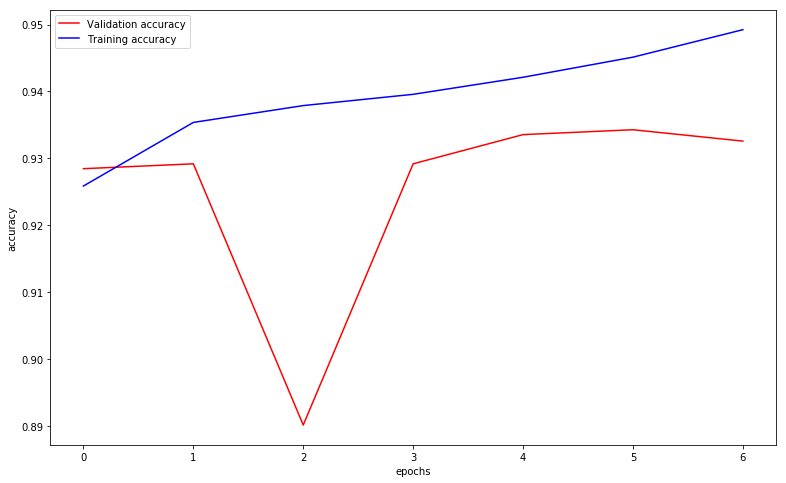

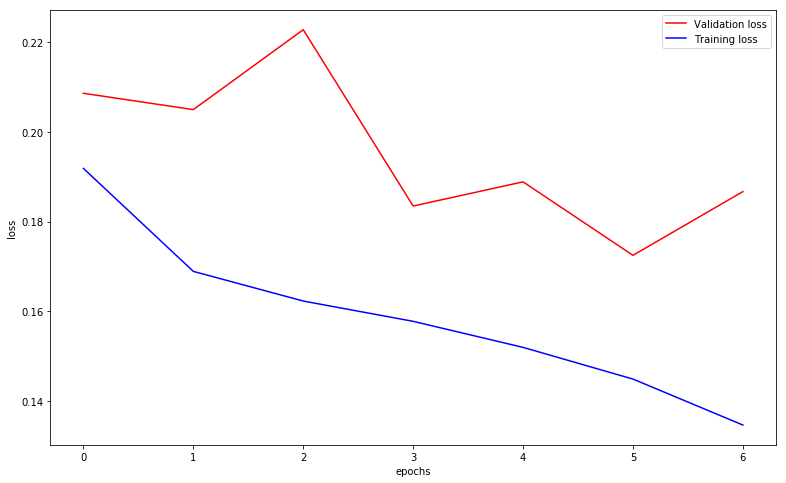

In [22]:
plot_acc_loss(hist)

# Saving of the model

In [14]:
def save_model(model,name,path):
    model_json = model.to_json()
    with open(path+name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
        model.save_weights(path+name+".h5")
        print("Saved model to disk")
        
def load_model(name,path):
    from keras.models import model_from_json
    # load json and create model
    json_file = open(path+name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path+name+".h5")
    print("Loaded model from disk")
    return loaded_model


In [15]:
save_model(NN,"Pre_training","models/review_rating")

Saved model to disk


In [17]:
NN = load_model("review_ratingPre_training","models/")
NN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [ ]:
NN_loaded = load_model("labelled+books_final","models/")
NN_loaded.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
NN_loaded.evaluate(x_vec_test,y_vec_test)

# Utilisation of the model for live prediction

In [107]:
def predict(sentence,word2Vec_model,model,max_len=50):
    sentence = sentence.split(" ")
    good_sentence = []
    unusued_words = []
    for i in range(len(sentence)):
        try :
            sentence[i]=sentence[i].lower()
            good_sentence.append(word2Vec_model.wv[sentence[i]])
        except : 
            unusued_words.append(sentence[i])
    sentence_length = len(good_sentence)
    if(sentence_length<max_len):    
        for j in range(max_len-sentence_length):
            good_sentence.append([0]*300)

    good_sentence = np.array(good_sentence)        
    good_sentence = np.reshape(good_sentence, (1,good_sentence.shape[0], good_sentence.shape[1]))
    return model.predict(good_sentence)

In [108]:
def vote(score):
    import numpy as np
    neg=[]
    pos=[]
    for s in score :
        neg.append(s[0][0])
        pos.append(s[0][1])
    sup_neg = [n for n in neg if n > 0.5]
    sup_pos = [p for p in pos if p > 0.5]

    return [np.mean(neg),np.mean(pos)]
    
def predict(sentence,word2Vec_model,model,max_len=50,word_length=300):
    import numpy as np
    sentence = sentence.split(" ")
    good_sentence = []
    unusued_words = []
    for i in range(len(sentence)):
        try :
            sentence[i]=sentence[i].lower()
            good_sentence.append(word2Vec_model.wv[sentence[i]])
        except : 
            unusued_words.append(sentence[i])
    sentence_length = len(good_sentence)
    
    if(sentence_length<max_len):    
        for j in range(max_len-sentence_length):
            good_sentence.append([0]*word_length)     
            
    if (sentence_length > max_len) :
        predictions = []
        ind = 0
        for i in range(int(np.ceil(sentence_length/max_len))):
            sent_tmp = good_sentence[ind:ind+max_len]
            if(len(sent_tmp)<max_len):
                for j in range(max_len-len(sent_tmp)):
                    sent_tmp.append([0]*word_length)    
            sent_tmp = np.array(sent_tmp)        
            sent_tmp = np.reshape(sent_tmp, (1,sent_tmp.shape[0], sent_tmp.shape[1]))
            try :
                predictions.append(model.predict(sent_tmp))
                ind+=max_len                    
            except : 
                print("Erreur au découpage no :"+str(i))
        return vote(predictions)
    
    good_sentence = np.array(good_sentence)        
    good_sentence = np.reshape(good_sentence, (1,good_sentence.shape[0], good_sentence.shape[1]))
    return np.squeeze(model.predict(good_sentence))

In [109]:
best=Final
sentence =input()
print(" Négatif        Positif")
print(predict(sentence,model,best))

It was amazing
 Négatif        Positif


/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


[4.2402942e-04 9.9957591e-01]
